In [ ]:
pip install pyexiftool

In [ ]:
pip install pyproj

In [18]:
pip install shapely

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 640.0 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.4 MB 787.7 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.4 MB 2.0 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.4 MB 3.3 MB/s eta 0:00:01
   ----------------------- ---------------- 0.9/1.4 MB 3.9 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.4 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Read Exifdata from UAV-Images

In [26]:
import os
import math
import re
import subprocess

# Path to the folder containing the images
folder_path = "../testzone/circle"
# Path to all images in the folder
#folder_path = r"E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_14\Zone_14"


# Path to the ExifTool executable
exifToolPath = "../exiftool.exe"  # Adjust if necessary

# Initialize the dictionary to store metadata
image_metadata = {}

# Filter for image files in the folder (common extensions)
valid_extensions = {'.jpg', '.jpeg', '.png'}
image_files = [f for f in os.listdir(folder_path) if os.path.splitext(f)[-1].lower() in valid_extensions]

# Process each image in the folder
for filename in image_files:
    image_path = os.path.join(folder_path, filename)
    
    # Initialize subprocess to call ExifTool
    process = subprocess.Popen([exifToolPath, image_path], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)

    # Read and parse metadata
    infoDict = {}
    for tag in process.stdout:
        line = tag.strip().split(':')  # Split each line at the ':'
        if len(line) > 1:  # Ensure valid key-value pair
            infoDict[line[0].strip()] = line[-1].strip()

    # Extract required metadata
    try:
        relAlt = float(infoDict.get("Relative Altitude", 0))  # Default to 0 if not found
        #print(relAlt)
        absAlt = float(infoDict.get("Absolute Altitude", 0))
        gpslat = infoDict.get("GPS Latitude", "")
        gpslon = infoDict.get("GPS Longitude", "")
        iw = float(infoDict.get("Image Width", 0))
        #print(iw)
        fov = infoDict.get("Field Of View", "0")
        #print(fov)
        gimbal_roll_deg = float(infoDict.get("Gimbal Roll Degree", 0))
        gimbal_yaw_deg = float(infoDict.get("Gimbal Yaw Degree", 0))
        gimbal_pitch_deg = float(infoDict.get("Gimbal Pitch Degree", 0))
        flight_yaw_deg = float(infoDict.get("Flight Yaw Degree", 0))

        
        # Parse latitude
        if gpslat:
            lat_ori = gpslat[-1]
            matches = re.findall(r'(\d+(\.\d+)?)', gpslat)
            gpslat = [float(match[0]) for match in matches]
            lat_deg, lat_min, lat_sec = gpslat
            lat_dec = abs(lat_deg) + lat_min / 60 + lat_sec / 3600
            if lat_ori == 'S':
                lat_dec = -lat_dec
        else:
            lat_dec = None

        # Parse longitude
        if gpslon:
            lon_ori = gpslon[-1]
            matches = re.findall(r'(\d+(\.\d+)?)', gpslon)
            gpslon = [float(match[0]) for match in matches]
            lon_deg, lon_min, lon_sec = gpslon
            lon_dec = abs(lon_deg) + lon_min / 60 + lon_sec / 3600
            if lon_ori == 'W':
                lon_dec = -lon_dec
        else:
            lon_dec = None

        # Calculate GSD
        if iw > 0 and relAlt < 88:
            fov_value = float(re.findall(r'\d+\.\d+', fov)[0]) if fov else 0
            fovrad = math.radians(fov_value / 2)
            gsd = (math.tan(fovrad) * relAlt) / (iw / 2)
        else:
            gsd = 0.022 # Default value

        # Store the data in a dictionary
        image_metadata[filename] = {
            'Latitude': lat_dec,
            'Longitude': lon_dec,
            'Relative Altitude': relAlt,
            'Absolute Altitude': absAlt,
            'GSD': gsd,
            "Gimbal Roll Degree": gimbal_roll_deg,
            "Gimbal Yaw Degree": gimbal_yaw_deg,
            "Gimbal Pitch Degree": gimbal_pitch_deg,
            "Flight Yaw Degree": flight_yaw_deg
        }
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# Output the collected metadata
for image_name, metadata in image_metadata.items():
    print(f"Image: {image_name}")
    for key, value in metadata.items():
        print(f"  {key}: {value}")
    print()


Image: DJI_0034.JPG
  Latitude: 5.697558333333333
  Longitude: -0.01368888888888889
  Relative Altitude: 90.2
  Absolute Altitude: 164.23
  GSD: 0.022
  Gimbal Roll Degree: 0.0
  Gimbal Yaw Degree: -5.5
  Gimbal Pitch Degree: -89.9
  Flight Yaw Degree: -8.0

Image: DJI_0035.JPG
  Latitude: 5.697691666666667
  Longitude: -0.013708333333333335
  Relative Altitude: 90.2
  Absolute Altitude: 164.1
  GSD: 0.022
  Gimbal Roll Degree: 0.0
  Gimbal Yaw Degree: -5.5
  Gimbal Pitch Degree: -89.9
  Flight Yaw Degree: -8.0

Image: DJI_0036.JPG
  Latitude: 5.697825
  Longitude: -0.013727777777777778
  Relative Altitude: 90.1
  Absolute Altitude: 164.09
  GSD: 0.022
  Gimbal Roll Degree: 0.0
  Gimbal Yaw Degree: -5.5
  Gimbal Pitch Degree: -89.9
  Flight Yaw Degree: -8.0

Image: DJI_0037.JPG
  Latitude: 5.697958333333333
  Longitude: -0.013747222222222223
  Relative Altitude: 90.2
  Absolute Altitude: 164.07
  GSD: 0.022
  Gimbal Roll Degree: 0.0
  Gimbal Yaw Degree: -5.5
  Gimbal Pitch Degree: -90.

### Save output to CSV

In [27]:
import csv

# Function to save image metadata to a CSV file
def save_metadata_to_csv(image_metadata, output_file):
    # Open the CSV file for writing
    with open(output_file, mode='w', newline='', encoding='utf-8') as csvfile:
        # Create a CSV writer
        writer = csv.writer(csvfile)
        
        # Write the header row
        # Use the keys from the first image's metadata as the header
        header = ['Image'] + list(next(iter(image_metadata.values())).keys())
        writer.writerow(header)
        
        # Write the metadata rows
        for image, metadata in image_metadata.items():
            # Combine the image name and metadata values
            row = [image] + [metadata[key] for key in metadata]
            writer.writerow(row)

# Example usage
output_csv = 'image_metadata_zone14.csv'  # Specify the output file name
save_metadata_to_csv(image_metadata, output_csv)
print(f"Metadata saved to {output_csv}")

Metadata saved to image_metadata_zone14.csv


### Calculate Drone Movement between Pictures

In [9]:
import math
from pyproj import Proj, transform


# Function to calculate pixel differences with middle point correction and yaw adjustments
def calculate_pixel_differences_with_middle_point_correction(image_metadata):
    # Sort images by their filenames to ensure correct order
    sorted_images = sorted(image_metadata.keys())
    results = []

    for i in range(len(sorted_images) - 1):
        # Get metadata for consecutive images
        img1 = sorted_images[i]
        img2 = sorted_images[i + 1]

        meta1 = image_metadata[img1]
        meta2 = image_metadata[img2]

        # Extract latitude, longitude, GSD, gimbal, flight angles, and altitude
        lat1, lon1, gsd1, altitude1 = meta1['Latitude'], meta1['Longitude'], meta1['GSD'], meta1['Relative Altitude']
        lat2, lon2, gsd2, altitude2 = meta2['Latitude'], meta2['Longitude'], meta2['GSD'], meta2['Relative Altitude']

        gimbal_pitch1, gimbal_yaw1, flight_yaw1 = (
            meta1.get('Gimbal Pitch Degree', -90),  # Default to downward (-90)
            meta1.get('Gimbal Yaw Degree', 0),
            meta1.get('Flight Yaw Degree', 0)
        )
        gimbal_pitch2, gimbal_yaw2, flight_yaw2 = (
            meta2.get('Gimbal Pitch Degree', -90),
            meta2.get('Gimbal Yaw Degree', 0),
            meta2.get('Flight Yaw Degree', 0)
        )

        # Check if metadata is valid
        if None in (lat1, lon1, gsd1, altitude1, lat2, lon2, gsd2, altitude2):
            print(f"Skipping image pair {img1} and {img2} due to missing data.")
            continue

        # Average GSD and altitude for the two images
        avg_gsd = (gsd1 + gsd2) / 2
        avg_altitude = (altitude1 + altitude2) / 2

        # Create a projection object for WGS84 (lat/lon) to UTM (zone determined automatically)
        utm_proj_1 = Proj(proj="utm", zone=32, ellps="WGS84")  # Use appropriate UTM zone for your location
        utm_x1, utm_y1 = utm_proj_1(lon1, lat1) 
        utm_proj_2 = Proj(proj="utm", zone=32, ellps="WGS84")  # Use appropriate UTM zone for your location
        utm_x2, utm_y2 = utm_proj_2(lon2, lat2)
        #print(f"UTM Coordinates: X = {utm_x1}, Y = {utm_y1}")
        #print(f"UTM Coordinates: X = {utm_x2}, Y = {utm_y2}")

        x_utm_diff = utm_x2 - utm_x1
        y_utm_diff = utm_y2 - utm_y1
        #print(f"UTM Differences: dX = {x_utm_diff}, dY = {y_utm_diff}")

        # Convert ground distances to pixel distances
        delta_x_pixels = x_utm_diff / avg_gsd
        delta_y_pixels = y_utm_diff / avg_gsd
        #print("delta_x_pixels",delta_x_pixels)
        #print("delta_y_pixels",delta_y_pixels)

        # Average gimbal and flight yaw
        avg_gimbal_yaw = (gimbal_yaw1 + gimbal_yaw2) / 2
        avg_flight_yaw = (flight_yaw1 + flight_yaw2) / 2 

        # Combined yaw adjustment
        avg_total_yaw = avg_gimbal_yaw + avg_flight_yaw
        #print("avg_total_yaw",avg_total_yaw)

        # Adjust pixel differences for yaw
        delta_x_corrected = delta_x_pixels * math.cos(math.radians(avg_total_yaw)) - delta_y_pixels * math.sin(math.radians(avg_total_yaw))
        delta_y_corrected = delta_x_pixels * math.sin(math.radians(avg_total_yaw)) + delta_y_pixels * math.cos(math.radians(avg_total_yaw))
        #print("delta_x_corrected",delta_x_corrected)
        #print("delta_y_corrected",delta_y_corrected)


        # Store results
        results.append({
            'image1': img1,
            'image2': img2,
            'delta_x_pixels': delta_x_corrected,
            'delta_y_pixels': delta_y_corrected
        })

    return results

        

# Use the metadata from the first program
# Assuming `image_metadata` was generated by the first program
pixel_differences = calculate_pixel_differences_with_middle_point_correction(image_metadata)

# Print results
for diff in pixel_differences:
    print(diff)


{'image1': 'DJI_0034.JPG', 'image2': 'DJI_0035.JPG', 'delta_x_pixels': 72.74038065661384, 'delta_y_pixels': 681.6230729783528}
{'image1': 'DJI_0035.JPG', 'image2': 'DJI_0036.JPG', 'delta_x_pixels': 72.74068096928141, 'delta_y_pixels': 681.623073671418}
{'image1': 'DJI_0036.JPG', 'image2': 'DJI_0037.JPG', 'delta_x_pixels': 72.14612528874247, 'delta_y_pixels': 681.6862933009941}
{'image1': 'DJI_0037.JPG', 'image2': 'DJI_0038.JPG', 'delta_x_pixels': 72.1464255867055, 'delta_y_pixels': 681.6862942431532}
{'image1': 'DJI_0038.JPG', 'image2': 'DJI_0039.JPG', 'delta_x_pixels': 65.71184616303015, 'delta_y_pixels': 654.2490254963534}
{'image1': 'DJI_0039.JPG', 'image2': 'DJI_0040.JPG', 'delta_x_pixels': 72.74187079562722, 'delta_y_pixels': 681.6230778422502}
{'image1': 'DJI_0040.JPG', 'image2': 'DJI_0041.JPG', 'delta_x_pixels': 72.74217106857115, 'delta_y_pixels': 681.6230785285263}
{'image1': 'DJI_0041.JPG', 'image2': 'DJI_0042.JPG', 'delta_x_pixels': 72.14761543346013, 'delta_y_pixels': 681.6

### Cross Correlation

In [44]:
import os
import numpy as np
from skimage.registration import phase_cross_correlation
from skimage import io
import math
from skimage.transform import rotate

def preprocess_image(image):
    """Preprocess the image by converting it to grayscale and normalizing."""
    if image.ndim == 3:
        image = image.mean(axis=2)  # Convert to grayscale by averaging color channels
    return image.astype(np.float32) / 255.0  # Normalize the image

def rotate_shift(shift, yaw):
    """Apply yaw rotation to the shift vector."""
    yaw_rad = math.radians(yaw)
    rotation_matrix = np.array([
        [math.cos(yaw_rad), -math.sin(yaw_rad)],
        [math.sin(yaw_rad), math.cos(yaw_rad)]
    ])
    return rotation_matrix.dot(shift)

def estimate_shift_and_rotation(image1, image2, yaw1, yaw2):
    """Estimate shift and detect rotation between two images."""
    image1 = preprocess_image(image1)
    image2 = preprocess_image(image2)

    # Compute the initial pixel shift using cross-correlation
    shift, _, _ = phase_cross_correlation(image1, image2, upsample_factor=10)

    #print("shift",shift)

    # Detect if there’s a direction change
    yaw_diff = yaw2 - yaw1
    print("yaw_diff",yaw_diff)
    rotation_detected = abs(yaw_diff) > 1  # Small threshold to account for noise
    corrected_shift = shift   # Initialize corrected shift
    

    rotation_angle = 0.0
    if rotation_detected:
        # Estimate the rotation angle based on yaw difference
        rotation_angle = yaw_diff
        
        # Rotate the second image for alignment
        image2_rotated = rotate(image2, angle=-rotation_angle, resize=False)
        
        # Recompute the shift after rotation correction
        corrected_shift, _, _ = phase_cross_correlation(image1, image2_rotated, upsample_factor=10)

    # Apply yaw correction to the shift vector
    corrected_shift = rotate_shift(corrected_shift, yaw_diff)

    return corrected_shift, rotation_angle

def process_image_folder_with_rotation(folder_path, image_metadata):
    """
    Process all images in the folder, estimating shifts and rotations between consecutive pairs.
    
    Args:
        folder_path (str): Path to the folder containing images.
        image_metadata (dict): Metadata for images, including yaw angles.
        
    Returns:
        dict: Dictionary containing shifts and rotations for each image pair.
    """
    images = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])
    results = {}

    for i in range(len(images) - 1):
        img1_path = os.path.join(folder_path, images[i])
        img2_path = os.path.join(folder_path, images[i + 1])

        # Load the images
        image1 = io.imread(img1_path)
        image2 = io.imread(img2_path)

        if image1 is None or image2 is None:
            print(f"Error loading images: {img1_path}, {img2_path}")
            continue

        # Get yaw angles from metadata
        yaw1 = image_metadata.get(images[i], {}).get('Gimbal Yaw Degree', 0)
        yaw2 = image_metadata.get(images[i + 1], {}).get('Gimbal Yaw Degree', 0)
        
        # Estimate shift and rotation
        shift, rotation_angle = estimate_shift_and_rotation(image1, image2, yaw1, yaw2)
        
        # Store the result in the dictionary
        results[f"{images[i]}_{images[i+1]}"] = {
            "shift": {"y": shift[0], "x": shift[1]},
            "rotation_angle": rotation_angle
        }
        
        print(f"Between {images[i]} and {images[i + 1]}:")
        print(f"  Shift (y, x): {shift[0]:.2f}, {shift[1]:.2f}")
        if rotation_angle != 0.0:
            print(f"  Rotation detected: {rotation_angle:.2f} degrees")
    
    return results

# Example usage
#folder_path = "../testzone/circle"

# Process folder and save results
shift_results = process_image_folder_with_rotation(folder_path, image_metadata)

shifts_and_rotations = {
    pair: {
        'shift': data['shift'],
        'rotation_angle': data['rotation_angle']
    }
    for pair, data in shift_results.items()
}

# Print results dictionary
print("\nShifts and Rotations:")
for pair, data in shift_results.items():
    print(f"{pair}: Shift (y, x) = {data['shift']}, Rotation = {data['rotation_angle']:.2f}°")

#worked 18.4 sec for 5 pairs of images
#worked 37 sec for 10 pair of images


yaw_diff 0.0
Between DJI_0034.JPG and DJI_0035.JPG:
  Shift (y, x): -643.10, -16.20
yaw_diff 0.0
Between DJI_0035.JPG and DJI_0036.JPG:
  Shift (y, x): -655.00, -15.60
yaw_diff 0.0
Between DJI_0036.JPG and DJI_0037.JPG:
  Shift (y, x): -645.20, -5.70
yaw_diff 0.0
Between DJI_0037.JPG and DJI_0038.JPG:
  Shift (y, x): -651.20, -5.20
yaw_diff 0.0
Between DJI_0038.JPG and DJI_0039.JPG:
  Shift (y, x): -647.30, -11.10
yaw_diff 0.0
Between DJI_0039.JPG and DJI_0040.JPG:
  Shift (y, x): -666.50, -6.60
yaw_diff 0.0
Between DJI_0040.JPG and DJI_0041.JPG:
  Shift (y, x): -655.10, -5.40
yaw_diff 0.0
Between DJI_0041.JPG and DJI_0042.JPG:
  Shift (y, x): -659.50, 2.20
yaw_diff 0.0
Between DJI_0042.JPG and DJI_0043.JPG:
  Shift (y, x): -676.20, 0.10
yaw_diff 0.0
Between DJI_0043.JPG and DJI_0044.JPG:
  Shift (y, x): -676.70, 2.00

Shifts and Rotations:
DJI_0034.JPG_DJI_0035.JPG: Shift (y, x) = {'y': -643.0999755859375, 'x': -16.200000762939453}, Rotation = 0.00°
DJI_0035.JPG_DJI_0036.JPG: Shift (y

In [45]:
print(shift_results)

{'DJI_0034.JPG_DJI_0035.JPG': {'shift': {'y': -643.0999755859375, 'x': -16.200000762939453}, 'rotation_angle': 0.0}, 'DJI_0035.JPG_DJI_0036.JPG': {'shift': {'y': -655.0, 'x': -15.600000381469727}, 'rotation_angle': 0.0}, 'DJI_0036.JPG_DJI_0037.JPG': {'shift': {'y': -645.2000122070312, 'x': -5.699999809265137}, 'rotation_angle': 0.0}, 'DJI_0037.JPG_DJI_0038.JPG': {'shift': {'y': -651.2000122070312, 'x': -5.199999809265137}, 'rotation_angle': 0.0}, 'DJI_0038.JPG_DJI_0039.JPG': {'shift': {'y': -647.2999877929688, 'x': -11.100000381469727}, 'rotation_angle': 0.0}, 'DJI_0039.JPG_DJI_0040.JPG': {'shift': {'y': -666.5, 'x': -6.599999904632568}, 'rotation_angle': 0.0}, 'DJI_0040.JPG_DJI_0041.JPG': {'shift': {'y': -655.0999755859375, 'x': -5.400000095367432}, 'rotation_angle': 0.0}, 'DJI_0041.JPG_DJI_0042.JPG': {'shift': {'y': -659.5, 'x': 2.200000047683716}, 'rotation_angle': 0.0}, 'DJI_0042.JPG_DJI_0043.JPG': {'shift': {'y': -676.2000122070312, 'x': 0.10000000149011612}, 'rotation_angle': 0.0

### BoundingBox Matching

In [80]:
import os
import pandas as pd
import numpy as np
from shapely.geometry import box
from skimage.transform import rotate

def apply_shift_and_rotation(bbox, shift, rotation_angle, image_shape):
    """Applies a shift and rotation to a bounding box."""
    x, y, width, height = bbox
    cx, cy = x + width / 2, y + height / 2  # Compute center of the bounding box

    # Apply the shift
    cx += shift['x']  # Shift in x-direction
    cy += shift['y']  # Shift in y-direction

    # Apply the rotation
    if rotation_angle != 0.0:
        center_image = np.array(image_shape) / 2  # Image center
        center_bbox = np.array([cx, cy]) - center_image
        angle_rad = np.radians(rotation_angle)

        # Rotate the bbox center around the image center
        rotation_matrix = np.array([
            [np.cos(angle_rad), -np.sin(angle_rad)],
            [np.sin(angle_rad), np.cos(angle_rad)]
        ])
        rotated_center = rotation_matrix.dot(center_bbox) + center_image
        cx, cy = rotated_center

    # Return the transformed bounding box
    return round(cx - width / 2), round(cy - height / 2), width, height

def compute_iou(bbox1, bbox2):
    """Computes the Intersection over Union (IoU) for two bounding boxes."""
    box1 = box(bbox1[0], bbox1[1], bbox1[0] + bbox1[2], bbox1[1] + bbox1[3])
    box2 = box(bbox2[0], bbox2[1], bbox2[0] + bbox2[2], bbox2[1] + bbox2[3])
    intersection = box1.intersection(box2).area
    union = box1.union(box2).area
    return intersection / union if union > 0 else 0

def process_bounding_box_matching(detect_folder_path, shift_results, iou_threshold=0.5, confidence_threshold=0.5):
    """Processes bounding box matching between consecutive images using shifts and rotations."""
    shift_results = {k.lower(): v for k, v in shift_results.items()}  # Convert keys to lowercase for case-insensitive matching
    csv_files = sorted([f for f in os.listdir(detect_folder_path) if f.endswith('_detections.csv')])

    for i in range(len(csv_files) - 1):
        # Get the filenames for the current and next detection CSV files
        current_file = csv_files[i]
        next_file = csv_files[i + 1]

        # Load bounding boxes from CSV
        current_detections = pd.read_csv(os.path.join(detect_folder_path, current_file))
        next_detections = pd.read_csv(os.path.join(detect_folder_path, next_file))

        # Filter bounding boxes based on confidence threshold
        current_detections = current_detections[current_detections['confidence'] >= confidence_threshold]
        next_detections = next_detections[next_detections['confidence'] >= confidence_threshold]

        # Get image names with extensions (used in the results dictionary keys)
        current_image_name = current_file.replace('_detections.csv', '').lower()
        next_image_name = next_file.replace('_detections.csv', '').lower()

        #print(current_image_name)
        #print(next_image_name)
        # Create the key for the results dictionary
        pair_key = f"{current_image_name}_{next_image_name}"
        #print(pair_key)

        if pair_key not in shift_results:
            print(f"No shift/rotation data for {pair_key} Skipping.")
            continue

        shift = shift_results[pair_key]['shift']
        rotation_angle = shift_results[pair_key]['rotation_angle']

        # Get the image shape (assuming all images have the same shape)
        image_shape = (5472, 3648)  # Replace with actual image dimensions if available

        # Initialize a list to store the results
        matching_results = []
        # Match bounding boxes
        # Match bounding boxes
        header = f"\nMatching results between {current_file} and {next_file}:\n"
        matching_results.append(header)
        print(f"\nMatching results between {current_file} and {next_file}:")
        for _, bbox1 in current_detections.iterrows():
            bbox1_coords = list(bbox1[['x', 'y', 'width', 'height']].values)
            bbox1_meta = bbox1.to_dict()

            for _, bbox2 in next_detections.iterrows():
                bbox2_coords = list(bbox2[['x', 'y', 'width', 'height']].values)
                bbox2_meta = bbox2.to_dict()

                # Apply shift and rotation to bbox2
                transformed_bbox2_coords = list(apply_shift_and_rotation(bbox2_coords, shift, rotation_angle, image_shape))

                # Compute IoU
                iou = compute_iou(bbox1_coords, transformed_bbox2_coords)
                if iou >= iou_threshold:
                    matching_results.append(f"  BBox1: {bbox1_coords}, Meta1: {bbox1_meta}\n")
                    matching_results.append(f"  BBox2: {transformed_bbox2_coords}, Meta2: {bbox2_meta}\n")
                    matching_results.append(f"  IoU: {iou:.2f}\n")
                    print(iou)
        # Combine the results into a single string if needed
        matching_results_str = ''.join(matching_results)
    return matching_results_str

detect_folder_path = r"..\testzone\detect\circle"
match_results_str = process_bounding_box_matching(detect_folder_path, shift_results, iou_threshold=0.5, confidence_threshold=0.7)
#print(match_result_str)



Matching results between DJI_0034.jpg_detections.csv and DJI_0035.jpg_detections.csv:
0.8714757429514859
0.6561739771470697
0.8749423165666821
0.7519107542654211

Matching results between DJI_0035.jpg_detections.csv and DJI_0036.jpg_detections.csv:
0.6479221333984255
0.8873975770371487
0.6753896478737733
0.6626645116601246
0.8008658008658008
0.8447657062355348
0.5780683583635422
0.7310924369747899
0.7685415629666501
0.9352226720647774
0.8478842532950154

Matching results between DJI_0036.jpg_detections.csv and DJI_0037.jpg_detections.csv:
0.6642452161587526
0.8301331416640997
0.7964168961878041
0.8027863216935046
0.6772900763358779
0.8433734939759037
0.8490128231223285
0.7735368956743003
0.7781916596339086
0.7878787878787878
0.8520660386158008
0.6417849606752349
0.8295872496935023

Matching results between DJI_0037.jpg_detections.csv and DJI_0038.jpg_detections.csv:
0.8609201480698043
0.8816584108027414
0.7757488828818889
0.8996378685980342
0.8470905694319518
0.8044914134742405
0.8759

In [81]:
print(match_results_str)


Matching results between DJI_0043.jpg_detections.csv and DJI_0044.jpg_detections.csv:
  BBox1: [5241, 2032, 307, 199], Meta1: {'x': 5241, 'y': 2032, 'width': 307, 'height': 199, 'confidence': 0.8668884634971619, 'class': 'car', 'class_id': 0, 'detection_id': 'a94cec42-7b67-491b-8297-96265742ed94', 'image_path': 'C:\\Users\\felix\\Documents\\My_Python\\data\\Testzone\\DJI_0043.jpg', 'prediction_type': 'ObjectDetectionModel', 'image': 'DJI_0043.jpg'}
  BBox2: [5234, 2010, 307, 199], Meta2: {'x': 5232, 'y': 2687, 'width': 307, 'height': 199, 'confidence': 0.8706914186477661, 'class': 'car', 'class_id': 0, 'detection_id': 'bb22e8e6-e617-49bd-bf9d-cabf710f08f3', 'image_path': 'C:\\Users\\felix\\Documents\\My_Python\\data\\Testzone\\DJI_0044.jpg', 'prediction_type': 'ObjectDetectionModel', 'image': 'DJI_0044.jpg'}
  IoU: 0.77
  BBox1: [4557, 2220, 136, 210], Meta1: {'x': 4557, 'y': 2220, 'width': 136, 'height': 210, 'confidence': 0.8350833654403687, 'class': 'car', 'class_id': 0, 'detection

### Visualisation

In [86]:
def visualize_matches(image1_id, image2_id, match_results_str):
    """
    Visualizes the matching results between two images.
    """
    import matplotlib.pyplot as plt
    from PIL import Image
    import re  # Reguläre Ausdrücke zum Extrahieren von Koordinaten

    # Pfade zu den Bildern
    image1_path = f"DJI_{str(image1_id).zfill(4)}.jpg"
    image2_path = f"DJI_{str(image2_id).zfill(4)}.jpg"
    image1path = r"testzone\circle\DJI_0041.JPG"
    iamge2path = r"testzone\circle\DJI_0042.JPG"
    
    # Initialisierung
    bbox1 = None
    bbox2 = None

    # Match-Ergebnisse analysieren
    for line in match_results_str.split("\n"):
        line = line.strip()
        if "BBox1:" in line:
            # Extrahiere Koordinaten aus "BBox1"
            bbox1 = re.search(r"BBox1: \[([0-9,\s]+)\]", line)
            if bbox1:
                bbox1 = [int(coord) for coord in bbox1.group(1).split(",")]
        elif "BBox2:" in line:
            # Extrahiere Koordinaten aus "BBox2"
            bbox2 = re.search(r"BBox2: \(([0-9,\s.]+)\)", line)
            if bbox2:
                bbox2 = [int(float(coord)) for coord in bbox2.group(1).split(",")]

    if bbox1 is None or bbox2 is None:
        raise ValueError("Bounding boxes could not be extracted from the match results.")

    # Bilder laden
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path)

    # Visualisierung
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Bild 1 mit BBox1
    axs[0].imshow(image1)
    axs[0].add_patch(plt.Rectangle((bbox1[0], bbox1[1]), bbox1[2], bbox1[3],
                                    edgecolor='red', facecolor='none', linewidth=2))
    axs[0].set_title(f"Image: {image1_path}")
    axs[0].axis("off")

    # Bild 2 mit BBox2
    axs[1].imshow(image2)
    axs[1].add_patch(plt.Rectangle((bbox2[0], bbox2[1]), bbox2[2], bbox2[3],
                                    edgecolor='blue', facecolor='none', linewidth=2))
    axs[1].set_title(f"Image: {image2_path}")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


visualize_matches(41,42,match_results_str)


ValueError: Bounding boxes could not be extracted from the match results.

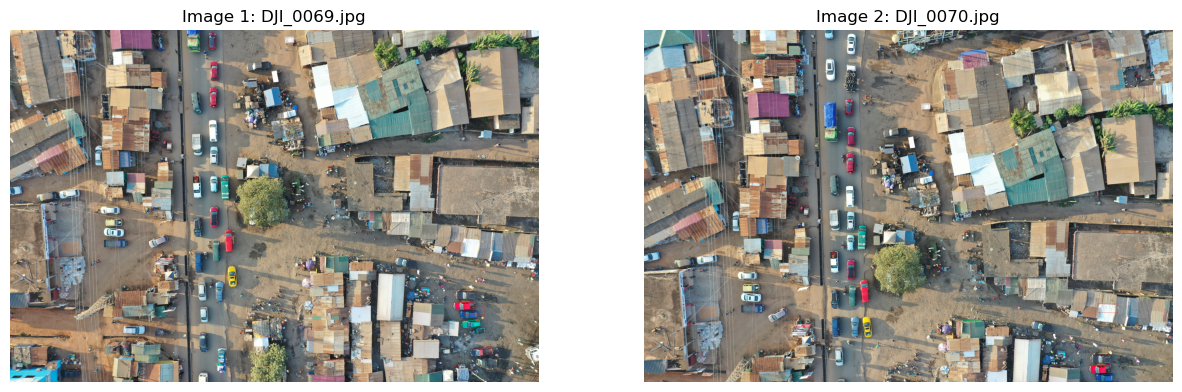

In [45]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def visualize_matching_results(match_results):
    """
    Visualize bounding box matching results between two consecutive images.
    
    Args:
        match_results (list): A list of dictionaries containing matching results.
    """
    for result in match_results:
        # Load images
        image1_path = result['meta1']['image_path']
        image2_path = result['meta2']['image_path']
        
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")
        
        # Create drawing contexts
        draw1 = ImageDraw.Draw(image1)
        draw2 = ImageDraw.Draw(image2)
        
        # Draw bounding boxes for the matched pair
        bbox1 = result['bbox1']  # [x, y, width, height]
        bbox2 = result['bbox2']  # [x, y, width, height]
        
        draw1.rectangle([bbox1[0], bbox1[1], bbox1[0] + bbox1[2], bbox1[1] + bbox1[3]],
                        outline="red", width=2)
        draw2.rectangle([bbox2[0], bbox2[1], bbox2[0] + bbox2[2], bbox2[1] + bbox2[3]],
                        outline="red", width=2)
        
        # Add IoU and other metadata as text
        iou = result['iou']
        draw1.text((bbox1[0], bbox1[1] - 10), f"IoU: {iou:.2f}", fill="red")
        draw2.text((bbox2[0], bbox2[1] - 10), f"IoU: {iou:.2f}", fill="red")
        
        # Display the images side-by-side
        fig, ax = plt.subplots(1, 2, figsize=(15, 10))
        ax[0].imshow(image1)
        ax[0].set_title(f"Image 1: {result['meta1']['image']}")
        ax[0].axis("off")
        
        ax[1].imshow(image2)
        ax[1].set_title(f"Image 2: {result['meta2']['image']}")
        ax[1].axis("off")
        
        plt.show()

# Example Usage
matching_results = [
    {
        'bbox1': [4698, 2861, 213, 91],
        'meta1': {
            'x': 4698, 'y': 2861, 'width': 213, 'height': 91,
            'confidence': 0.8363, 'class': 'car', 'class_id': 0,
            'detection_id': '3017fc4d-a25b-42b2-a57c-64faca5f85cb',
            'image_path': 'E:\\Data_MaterThesis\\Data_Ashaiman\\Raw_Images\\Zone_14\\Zone_14\\DJI_0069.jpg',
            'image': 'DJI_0069.jpg'
        },
        'bbox2': [4689.9, 2841.2, 213, 91],
        'meta2': {
            'x': 4723, 'y': 3516, 'width': 213, 'height': 91,
            'confidence': 0.7491, 'class': 'car', 'class_id': 0,
            'detection_id': '1a97dc09-3e75-4888-b742-d772e7b41e83',
            'image_path': 'E:\\Data_MaterThesis\\Data_Ashaiman\\Raw_Images\\Zone_14\\Zone_14\\DJI_0070.jpg',
            'image': 'DJI_0070.jpg'
        },
        'iou': 0.60
    }
    # Add more matches as needed
]

visualize_matching_results(matching_results)
